# MCMC Simulation of Potts model
$$
H(\sigma) = -J \sum_{\langle i,j \rangle} \delta_{\sigma_i, \sigma_j} - h \sum_i {\sigma_i} \,, \quad i \in \{1, \dots, N^2\}
$$
where $\sigma_i \in \{1, \dots, q\}$ is the spin at site $i$. Take $q=3$ and $q=10$ as concrete examples.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from numba import njit,prange,objmode,jit
import os.path
from tqdm import tqdm,trange

# setup of 2D q-state Potts model
@njit
def potts_energy(spins, J, h):
    """计算Potts模型的能量

    Args:
        spins: 自旋状态,shape=(N, N)的数组,其中N是格子数目
        J: 相邻自旋互相作用能量强度

    Returns:
        系统总能量,标量
    """

    # 获取形状
    N = spins.shape[0]

    # 计算相邻自旋互作用能
    E_J = J * np.sum(spins[:-1, :] == spins[1:, :])
    E_J += J * np.sum(spins[:, :-1] == spins[:, 1:])
    E_J += h * np.sum(spins)

    # 求和得到能量
    E = -E_J
    return E

# magnetization
@njit
def potts_magnetization(spins):
    """计算Potts模型的磁化强度

    Args:
        spins: 自旋状态,shape=(N, N)的数组,其中N是格子数目

    Returns:
        系统磁化强度,标量
    """

    # 获取形状
    N = spins.shape[0]

    # 计算磁化强度
    M = np.sum(spins) / N**2
    return M

In [25]:
q = 3
N = 20
J = 1
h = 0
k = 1
T_series = np.linspace(0.5,2.5,100)
n_steps = 400000

100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


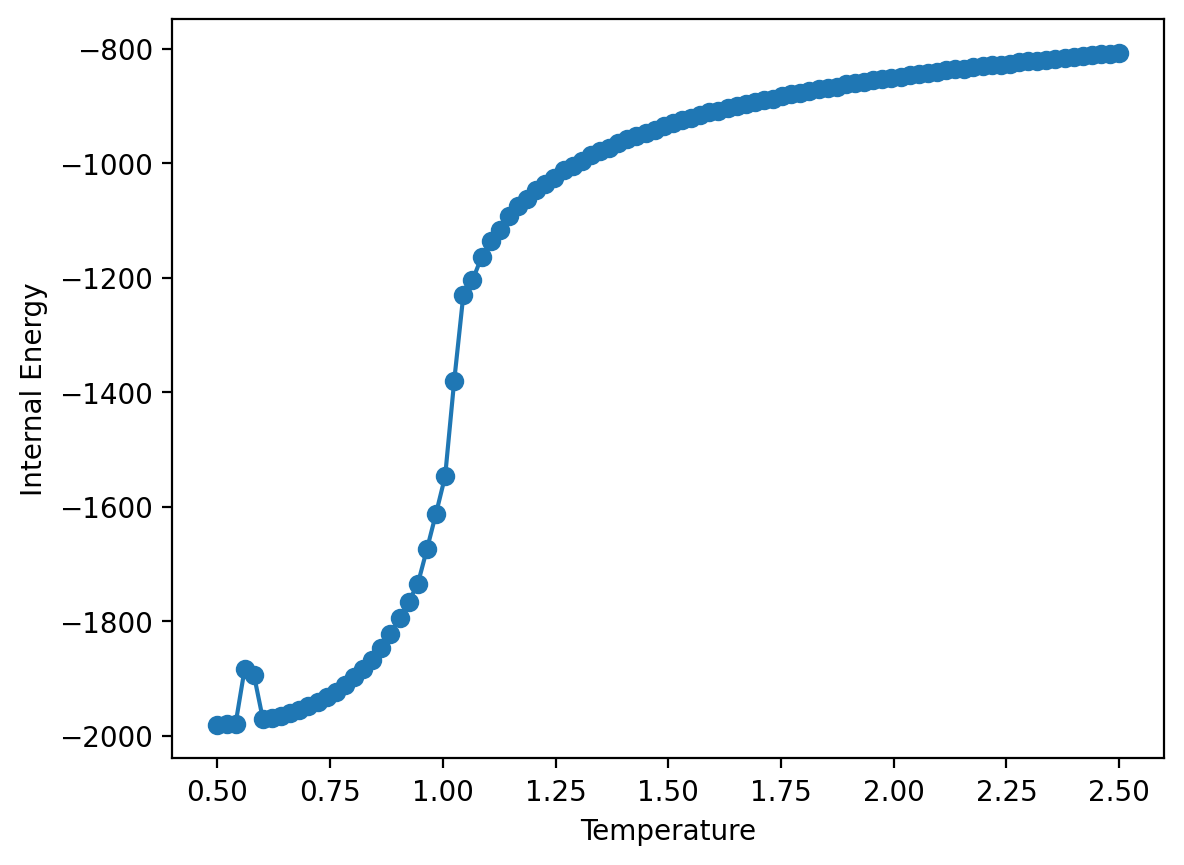

In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# internal energy
@jit(forceobj=True)
def internal_energy(spin_series, J, h):
    """计算内能
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
    Returns:
        内能,标量
    """
    
    # 计算能量
    E_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        E_series[i] = potts_energy(spin_series[i,:,:], J, h)
    # 求和得到内能
    E = np.mean(E_series)
    return E
# internal energy
U_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        U_series[i] = internal_energy(data, J, h)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, U_series, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Internal Energy')
plt.show()


100%|██████████| 100/100 [00:02<00:00, 35.49it/s]


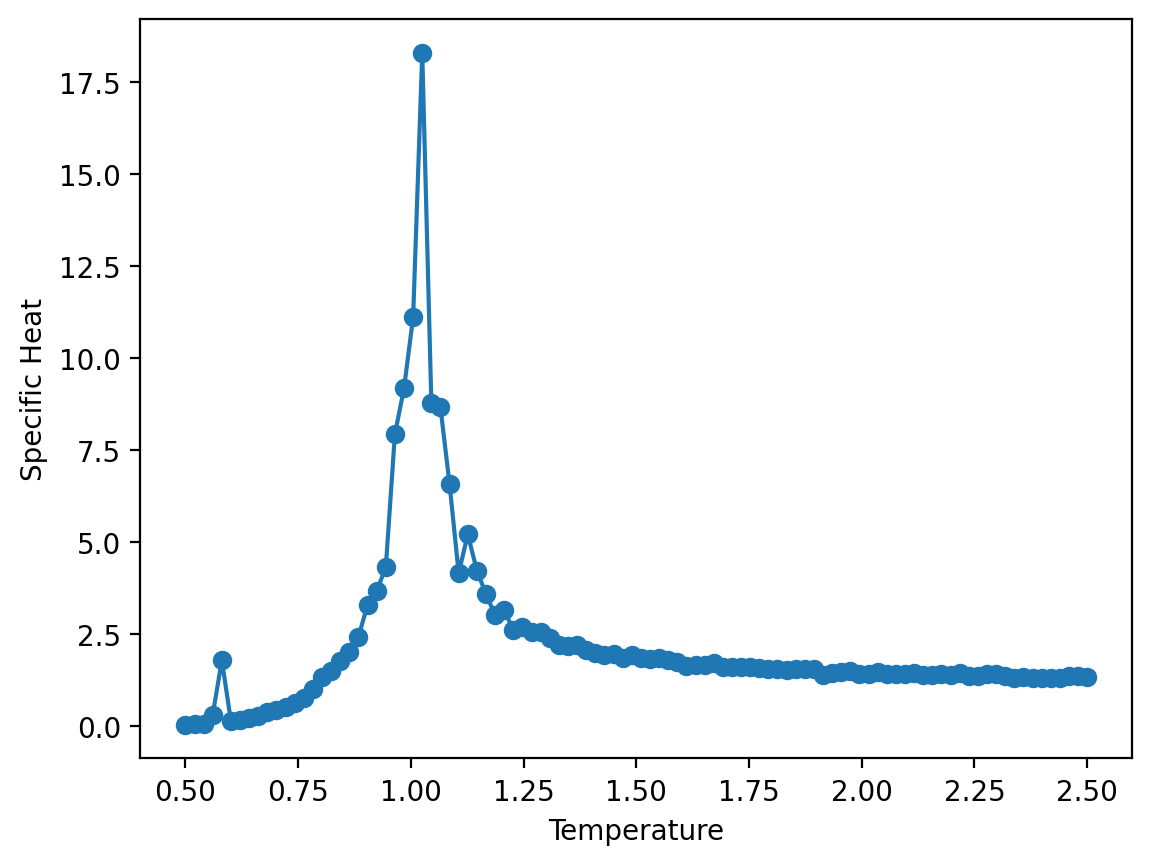

In [28]:
# specific heat
@jit
def specific_heat(spin_series, J, h, N):
    """计算比热
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
    Returns:
        比热,标量
    """
    
    # 计算能量
    E_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        E_series[i] = potts_energy(spin_series[i,:,:], J, h)
    # 计算能量平方
    E2_series = E_series**2
    # 求和得到比热
    C = np.mean(E2_series) - np.mean(E_series)**2
    C = C / N**2
    return C

# specific heat
C_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        C_series[i] = specific_heat(data, J, h, N)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, C_series, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.show()

In [29]:
# find critical temperature (peak of specific heat)
T_c = T_series[np.argmax(C_series)]
print('Critical Temperature: {:.2f}'.format(T_c))

Critical Temperature: 1.03


100%|██████████| 100/100 [00:01<00:00, 78.23it/s]


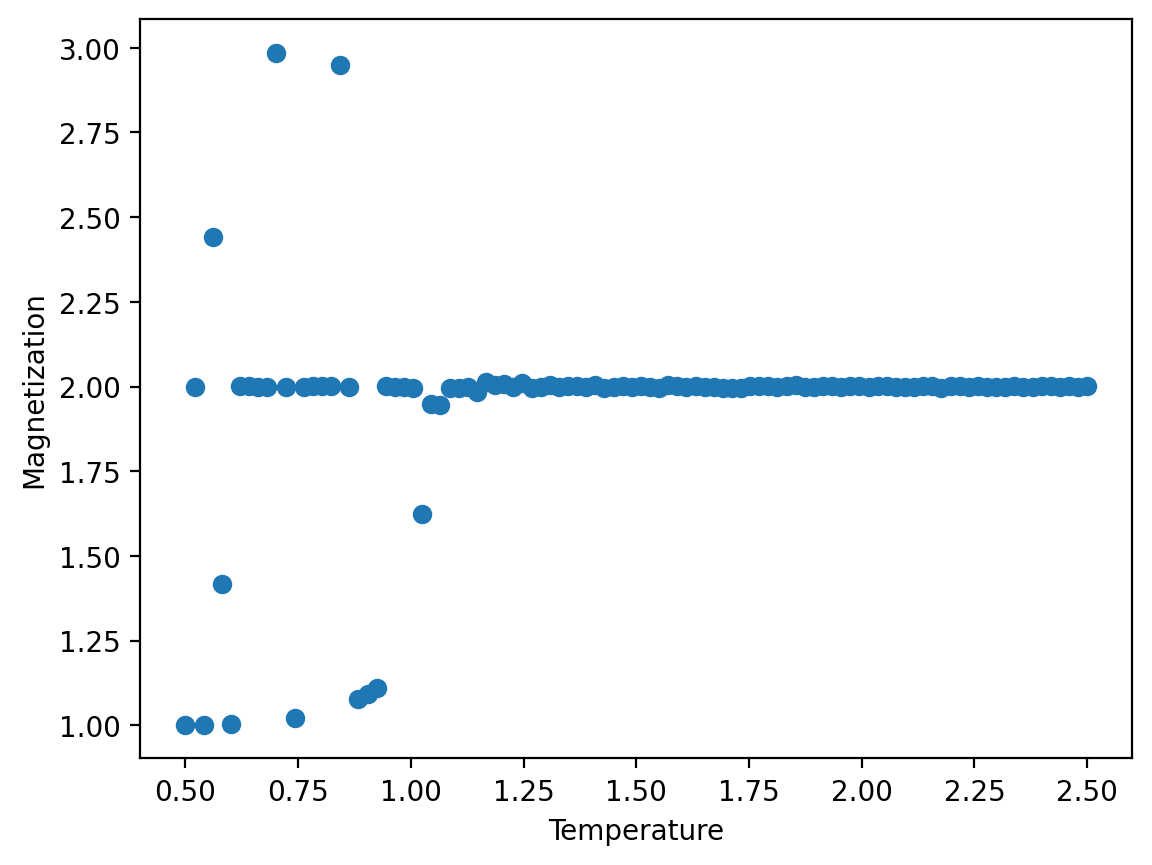

In [30]:
# magnetization
@jit
def magnetization(spin_series):
    """计算磁化强度
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
    Returns:
        磁化强度,标量
    """
    
    # 计算磁化强度
    M_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        M_series[i] = potts_magnetization(spin_series[i,:,:])
    # 求和得到磁化强度
    M = np.mean(M_series)
    return M

M_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        M_series[i] = magnetization(data)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, M_series, 'o')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


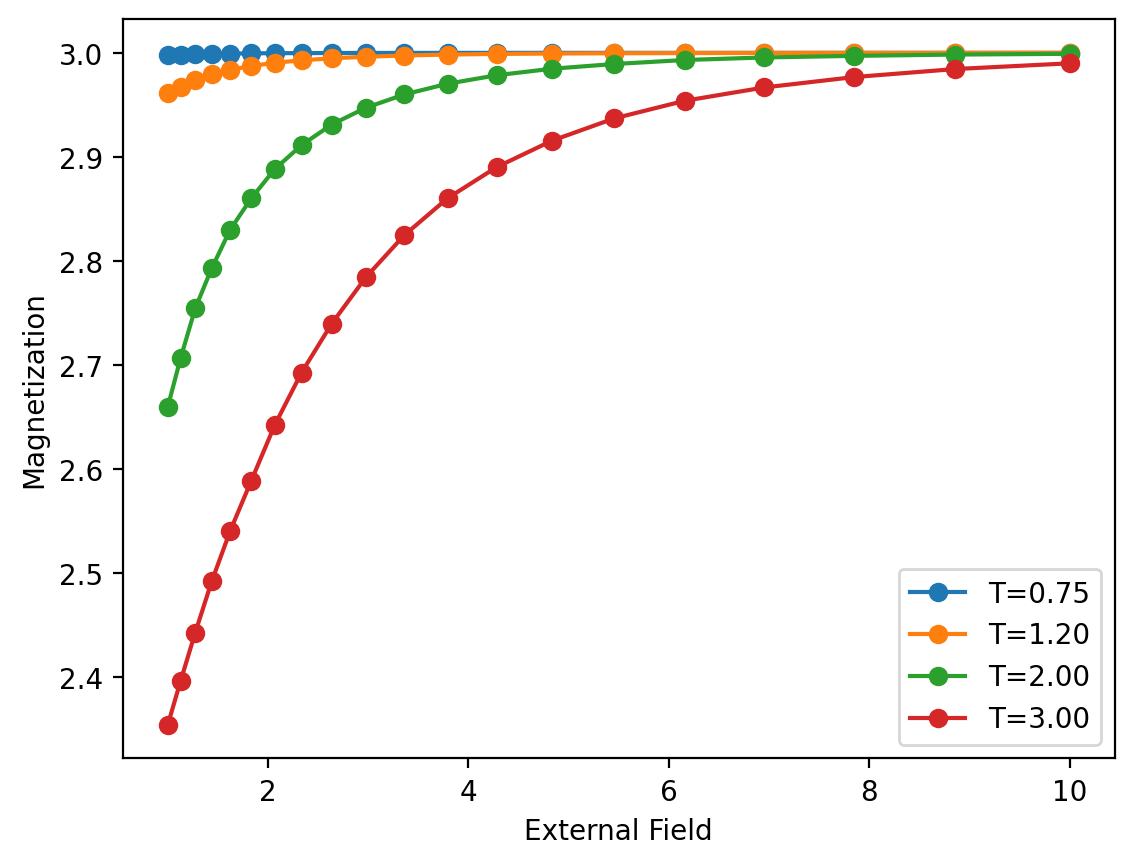

In [31]:
# Plot magnetization w.r.t h when T=0.75,1.2,2,3
T_set = [0.75,1.2,2,3]
h_series = np.logspace(0,1,20)
for i in trange(len(T_set)):
    T = T_set[i]
    beta = 1/(k*T)
    M_series = np.zeros(shape=(len(h_series)))
    for j in range(len(h_series)):
        h = h_series[j]
        # load data
        if os.path.isfile('Potts_Data_h/spin_history_{}_{:.2f}_{:.2f}.npy'.format(q, h, T)):
            data = np.load('Potts_Data_h/spin_history_{}_{:.2f}_{:.2f}.npy'.format(q, h, T))
            data = data[data.shape[0]//2:,:,:]
            M_series[j] = magnetization(data)
        else:
            raise ValueError(f'Simulation trajectory for T={T} ,q={q} and h={h} does not exist!')
    # plot
    plt.plot(h_series, M_series, 'o-', label='T={:.2f}'.format(T))
plt.xlabel('External Field')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2532851/357622010.py:50: RuntimeWarning: invalid value encountered in log
  xi_series[i] = characteristic_length(Gamma)
100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


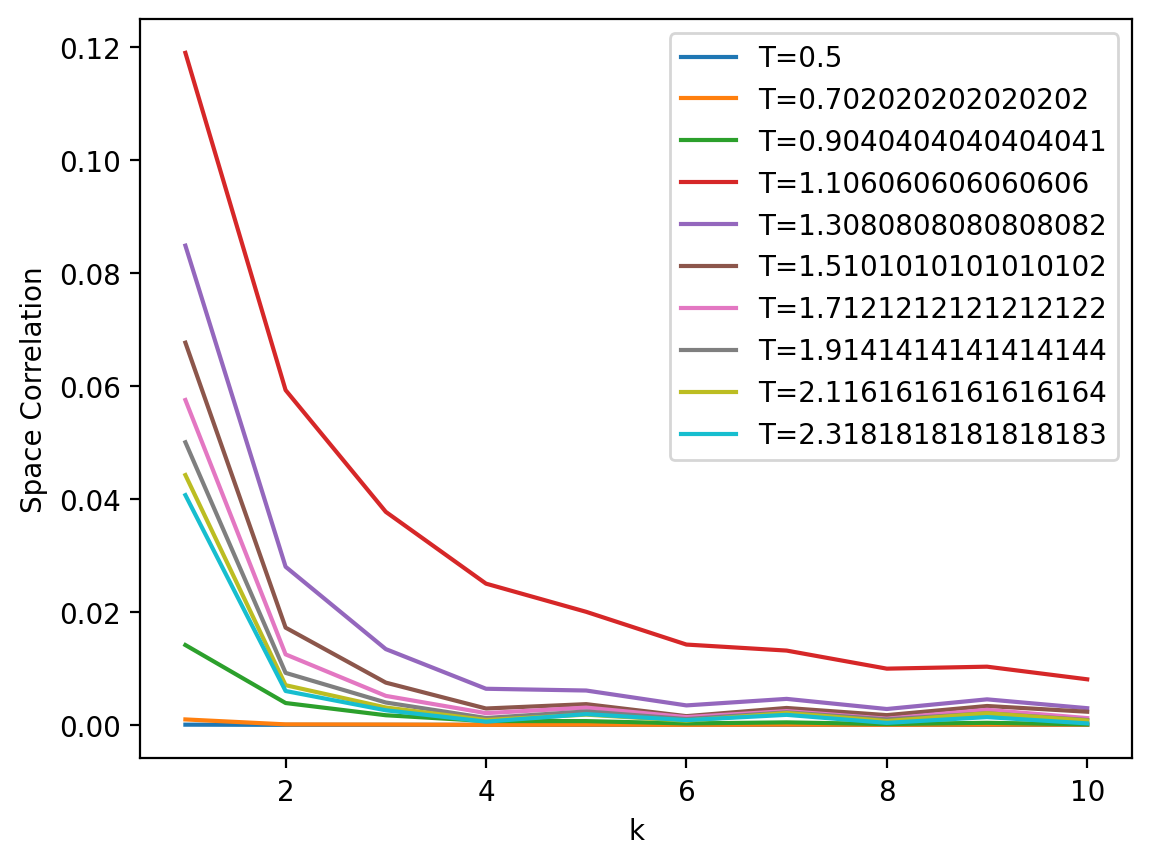

In [11]:
# space correlation and characteristic length
@jit(forceobj=True)
def space_correlation(spin_series, k):
    """计算空间相关函数
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        k: |i-j|
    Returns:
        Gamma: 空间相关函数 \Gamma(k) = 1/(4N^2) sum_i sum_{j=i+-(0,k) or (k,0)} <s_i s_j>-<s_i><s_j>
    """
    si_sj = 0
    N = spin_series.shape[1]
    si_sj += np.sum(spin_series * np.roll(spin_series,k,1))
    si_sj += np.sum(spin_series * np.roll(spin_series,k,2))
    si_sj_mean = si_sj/spin_series.shape[0]
    s_mean = np.mean(spin_series, axis = 0)
    si_mean_sj_mean= np.sum(s_mean*np.roll(s_mean,k,0)) + np.sum(s_mean*np.roll(s_mean,k,1))
    Gamma_k = 1/(4*N**2) * (si_sj_mean - si_mean_sj_mean)
    return Gamma_k

from scipy.stats import linregress

@jit(forceobj=True)
def characteristic_length(Gamma):
    """计算特征长度
    Args:
        Gamma: 空间相关函数
    Returns:
        xi: 特征长度,标量 Gamma(k) = exp(-k/xi) thus ln(Gamma(k)) = -k/xi
    """
        
    # 计算特征长度
    k = np.arange(1,len(Gamma)+1)
    log_Gamma = np.log(Gamma)
    slope, intercept, r_value, p_value, std_err = linregress(k, log_Gamma)
    xi = -1/slope
    return xi

xi_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        Gamma = [space_correlation(data, k) for k in range(1,11)]
        if i%10==0:
            plt.plot(np.arange(1,11), Gamma, label=f'T={T}')
        xi_series[i] = characteristic_length(Gamma)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
plt.xlabel('k')
plt.ylabel('Space Correlation')
plt.legend()
plt.show()

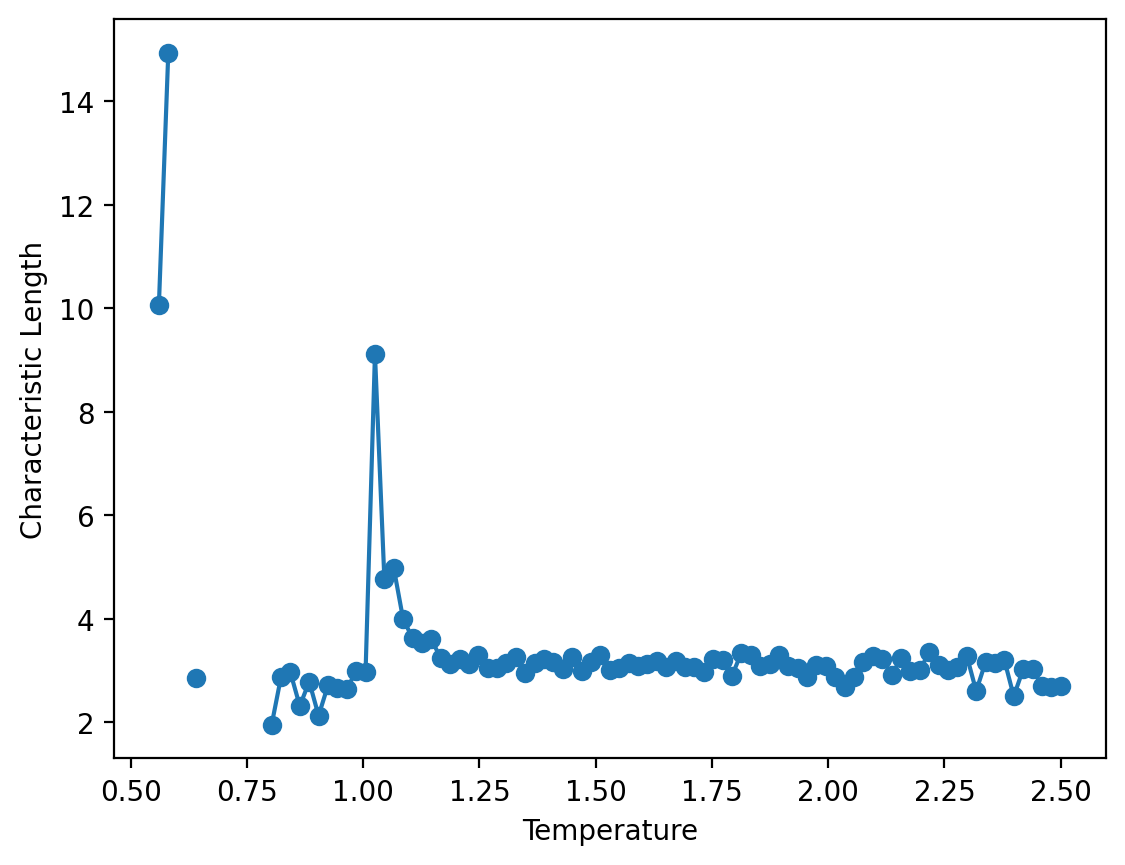

In [32]:
plt.plot(T_series, xi_series, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Characteristic Length')
plt.show()

26


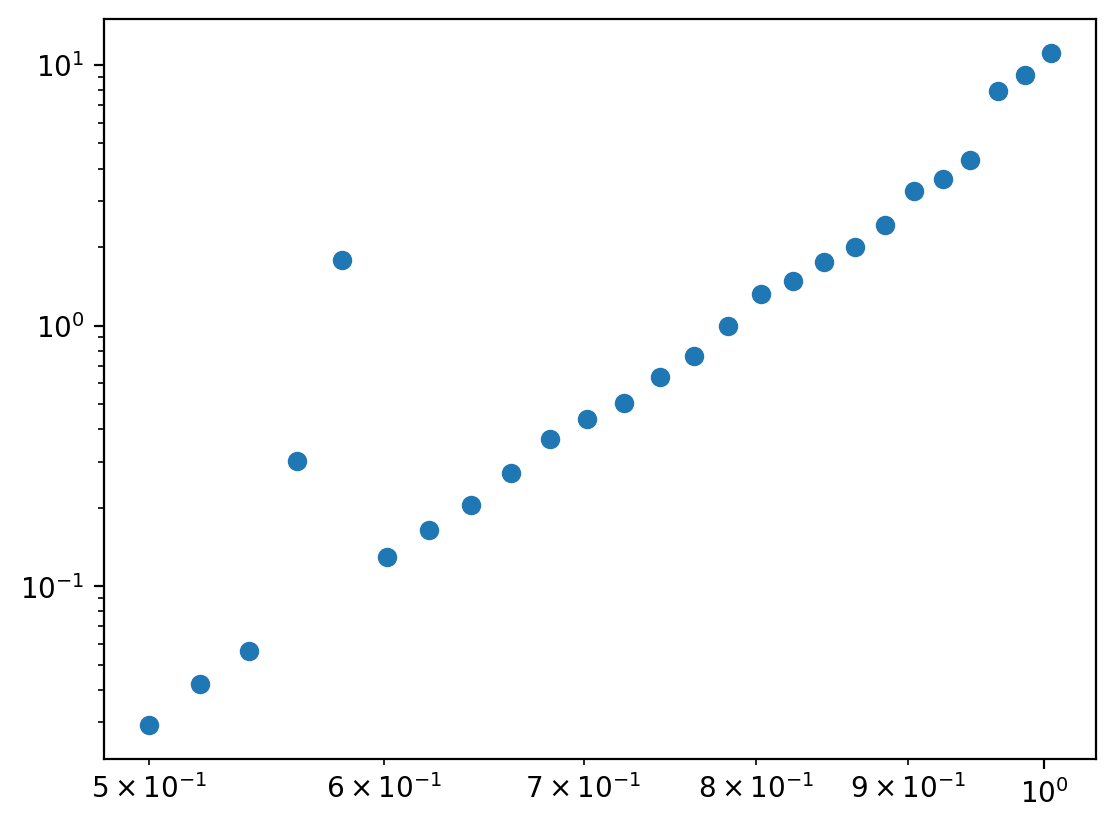

In [34]:
# For c, take log and linear fit
# find the index of the critical temperature
critical_idx = np.argwhere(T_series==T_c)[0][0]
print(critical_idx)
plt.loglog(T_series[:critical_idx], C_series[:critical_idx], 'o')

In [35]:
# linear fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.log(T_series[:critical_idx]), np.log(C_series[:critical_idx]))
print(f"gamma = {-slope}")

gamma = -7.172185336827465


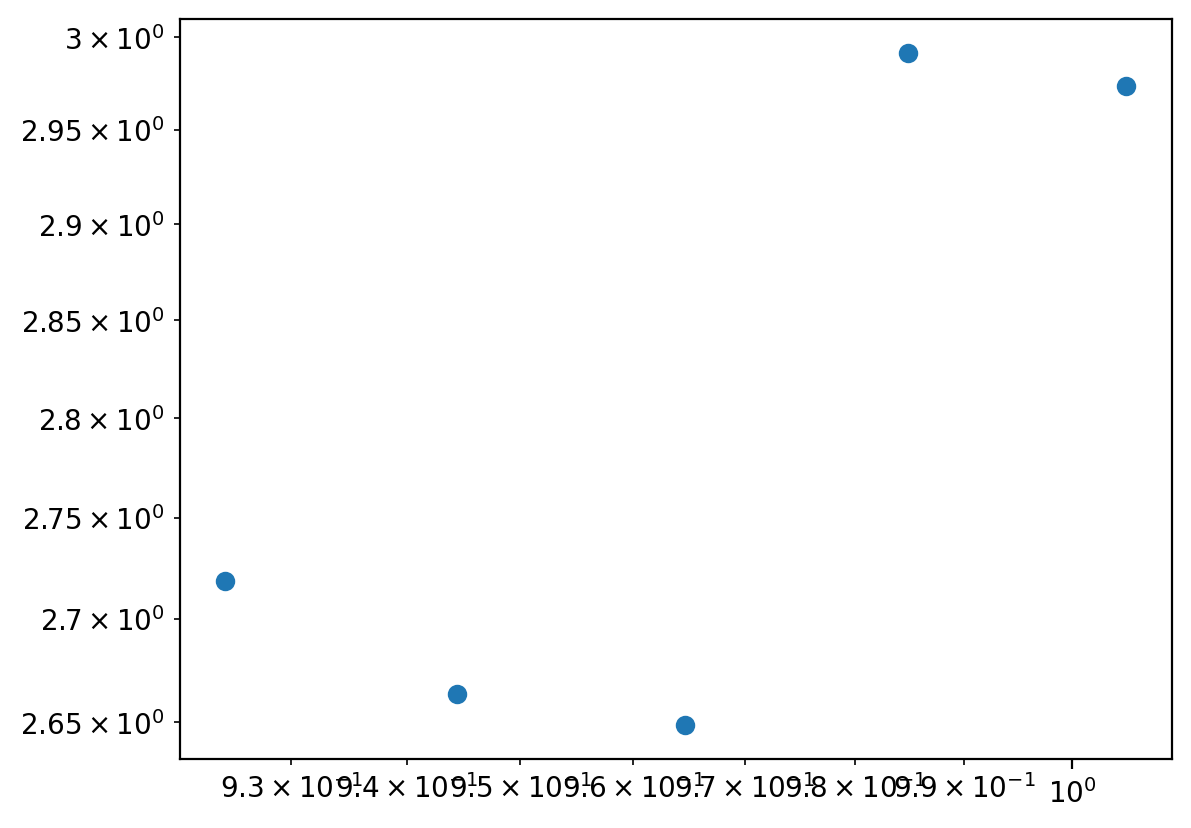

In [41]:
# linear fit for xi
# find the index of the critical temperature
critical_idx = np.argwhere(T_series==T_c)[0][0]
plt.loglog(T_series[critical_idx-5:critical_idx], xi_series[critical_idx-5:critical_idx], 'o')
# linear fit
slope, intercept, r_value, p_value, std_err = linregress(np.log(T_series[critical_idx-5:critical_idx]), np.log(xi_series[critical_idx-5:critical_idx]))

In [42]:
print(f"delta = {-slope}")

delta = -1.4021216091931956
